In [31]:
# import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [8]:
# loading data

import zipfile, os
zip_path = "archive (13).zip"
extract_path = "olist_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

['olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_products_dataset.csv',
 'olist_sellers_dataset.csv',
 'product_category_name_translation.csv']

In [10]:
orders = pd.read_csv(os.path.join(extract_path, "olist_orders_dataset.csv"), parse_dates=['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date'])
order_items = pd.read_csv(os.path.join(extract_path, "olist_order_items_dataset.csv"))
products = pd.read_csv(os.path.join(extract_path, "olist_products_dataset.csv"))

In [19]:
orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [20]:
# size of datsets

print("Orders:", orders.shape)
print("Order Items:", order_items.shape)
print("Products:", products.shape)

Orders: (99441, 8)
Order Items: (112650, 7)
Products: (32951, 9)


In [11]:
# merging the datasets  

data = order_items.merge(orders, on="order_id", how="left")
data = data.merge(products, on="product_id", how="left")

In [21]:
data.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_delay,purchase_to_delivery,estimated_time
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-9,7,15
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,-3,16,18
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,-14,7,21


In [12]:
# Feature Engineering 

data = data.dropna(subset=['order_delivered_customer_date','order_estimated_delivery_date'])
data['delivery_delay'] = (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days
data['purchase_to_delivery'] = (data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.days
data['estimated_time'] = (data['order_estimated_delivery_date'] - data['order_purchase_timestamp']).dt.days

In [15]:
features = data[['price','freight_value','product_weight_g','product_length_cm','product_height_cm','product_width_cm','purchase_to_delivery','estimated_time']]
target = data['delivery_delay']
features = features.fillna(features.median())
target = target.fillna(0)

In [16]:
# Train and test split , scale and model

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [18]:
# Evaluation

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MAE:", mae)
print("R2:", r2)

MAE: 0.4350900018311996
R2: 0.9969352621158742


In [22]:
# Prediction 1

sample_X = X_test[:5]
sample_y = y_test[:5]
sample_pred = model.predict(sample_X)

print("Actual Delivery Delays:", sample_y.values)
print("Predicted Delivery Delays:", sample_pred)

Actual Delivery Delays: [-18 -14   1  -6  -8]
Predicted Delivery Delays: [-17.91       -14.57         0.49        -6.          -8.76666667]


In [23]:
# Prediction 2

sample_X = X_test[20:30]
sample_y = y_test[20:30]
sample_pred = model.predict(sample_X)

print("Actual Delivery Delays:", sample_y.values)
print("Predicted Delivery Delays:", sample_pred)

Actual Delivery Delays: [ -7  -9 -11 -20 -12 -18  -9 -14 -13 -21]
Predicted Delivery Delays: [ -6.51        -9.53       -10.77       -20.59       -11.81857143
 -17.43        -9.32       -13.75       -13.74       -21.16      ]


In [24]:
# Aggregate orders per day

orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date
daily_orders = orders.groupby('order_purchase_date').size().reset_index(name='num_orders')
daily_orders = daily_orders.set_index('order_purchase_date')

In [25]:
# Train/test split

train_size = int(len(daily_orders)*0.8)
train = daily_orders.iloc[:train_size]
test = daily_orders.iloc[train_size:]

In [29]:
# importing module prophet

from prophet import Prophet

df = train.reset_index().rename(columns={'order_purchase_date':'ds','num_orders':'y'})
model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

18:52:23 - cmdstanpy - INFO - Chain [1] start processing
18:52:23 - cmdstanpy - INFO - Chain [1] done processing


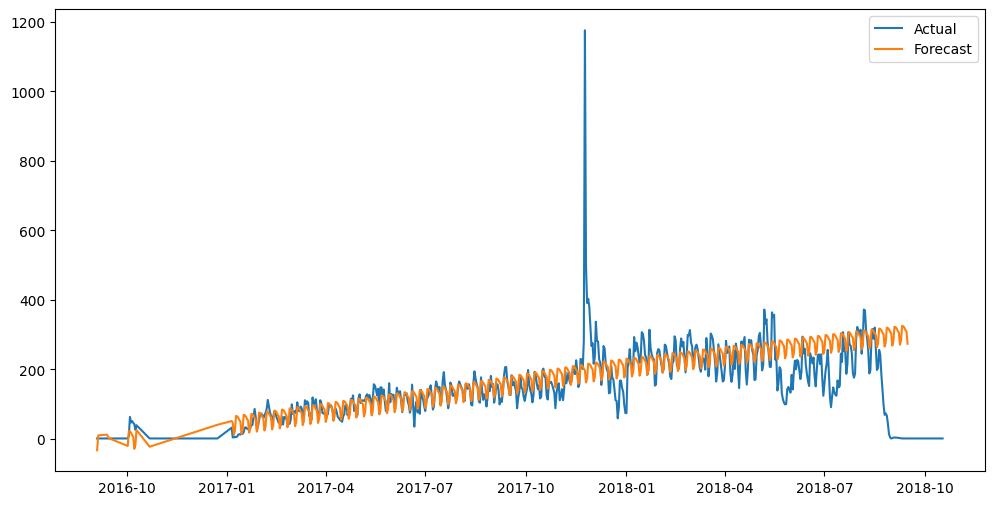

In [30]:
# Actual vs Forecasted daily orders

plt.figure(figsize=(12,6))
plt.plot(daily_orders.index, daily_orders['num_orders'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.legend()
plt.show()

In [32]:
# Evaluation

from sklearn.metrics import mean_absolute_error

y_true = test['num_orders'].values
y_pred = forecast['yhat'][-len(test):].values
mae = mean_absolute_error(y_true, y_pred)
print("MAE:", mae)

MAE: 111.86564540968585


In [35]:
# Prediction 3

train = daily_orders.iloc[:-7]
model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

print(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(7))

18:55:18 - cmdstanpy - INFO - Chain [1] start processing
18:55:18 - cmdstanpy - INFO - Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
627 2018-09-21  107.888760   43.501123  174.384059
628 2018-09-22   73.050019    7.562915  133.891225
629 2018-09-23   87.184096   17.194584  156.291229
630 2018-09-24  132.213685   65.272119  202.442328
631 2018-09-25  134.261008   64.610669  201.469690
632 2018-09-26  131.086486   70.010645  196.375822
633 2018-09-27  121.491717   55.784001  188.457773


In [36]:
# Prediction 4

test = daily_orders.iloc[-7:]
y_true = test['y'].values
y_pred = forecast['yhat'][-7:].values

print("Actual Orders:", y_true)
print("Predicted Orders:", y_pred)

Actual Orders: [1 1 1 1 1 1 1]
Predicted Orders: [107.88876041  73.05001866  87.18409575 132.213685   134.2610075
 131.08648634 121.49171726]


C:\Users\91866\AppData\Local\Temp\ipykernel_18852\1012429431.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


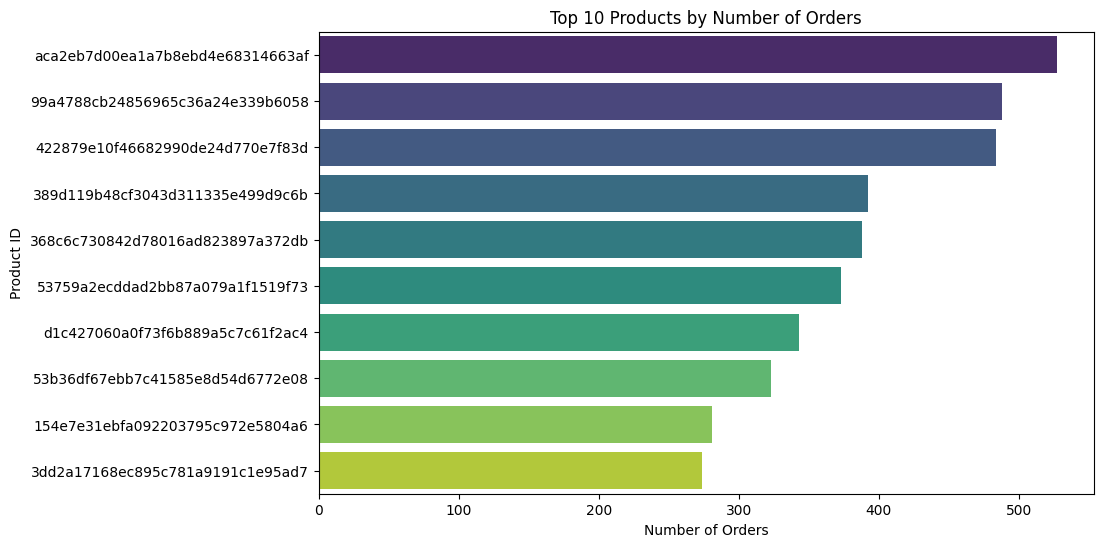

In [40]:
# Top 10 products by orders

import seaborn as sns
top_products = order_items['product_id'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.xlabel('Number of Orders')
plt.ylabel('Product ID')
plt.title('Top 10 Products by Number of Orders')
plt.show()

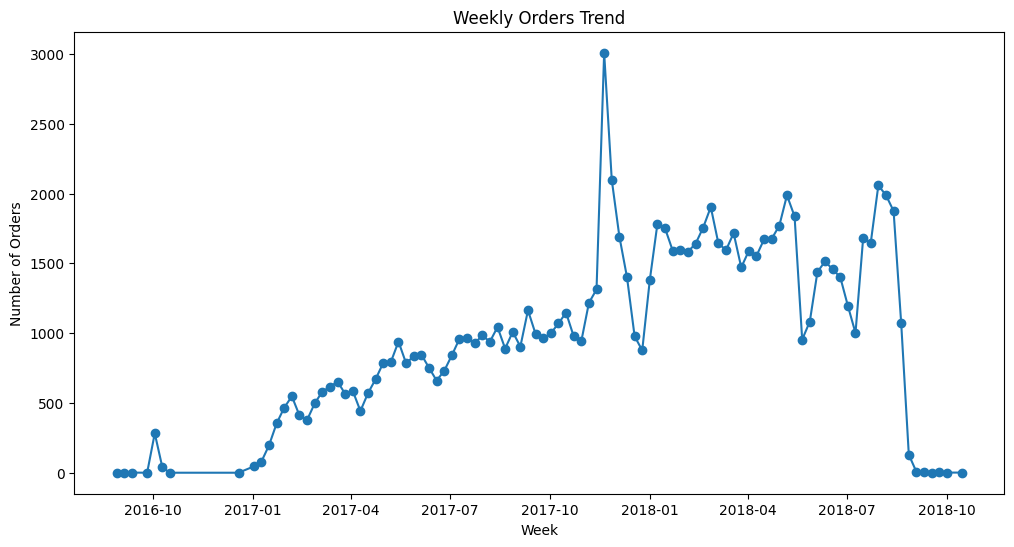

In [39]:
# weekly order trends

orders['order_week'] = orders['order_purchase_timestamp'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_orders = orders.groupby('order_week').size()

plt.figure(figsize=(12,6))
plt.plot(weekly_orders.index, weekly_orders.values, marker='o')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.title('Weekly Orders Trend')
plt.show()